In [1]:
import sqlite3
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

In [2]:
# Connect to the databases
deliveroo_conn = sqlite3.connect("./databases/deliveroo.db")
takeaway_conn = sqlite3.connect("./databases/takeaway.db")
ubereats_conn = sqlite3.connect("./databases/ubereats.db")
# Create cursors
deliveroo = deliveroo_conn.cursor()
takeaway = takeaway_conn.cursor()
ubereats = ubereats_conn.cursor()

In [3]:
geographic_df = gpd.read_file('./geodata/postaldistricts.shp')
geographic_df.rename(columns={'nouveau_PO': 'PostalCode'}, inplace=True)
geographic_df['PostalCode'] = geographic_df['PostalCode'].astype('int64')
geographic_df.head()

,Join_Count,PostalCode,FREQUENCY,CP_speciau,Shape_Leng,Shape_Area,geometry
0,1,5012,2,1,977.714223,3.838034e+04,"POLYGON Z ((185640.749 128034.551 0, 185693.14..."
1,1,5012,2,1,123.021423,8.601421e+02,"POLYGON Z ((185785.522 128270.324 0, 185777.35..."
2,1,5589,1,1,1197.205234,6.306885e+04,"POLYGON Z ((213820.048 94558.92 0, 214146.309 ..."
3,1094,5560,2,0,54736.127330,5.406061e+07,"POLYGON Z ((191350.123 101346.457 0, 191368.11..."
4,1357,5370,1,0,74754.001683,8.154068e+07,"POLYGON Z ((210593.768 123259.25 0, 211182.758..."


## 2. What is the distribution of restaurants per location?

<Axes: >

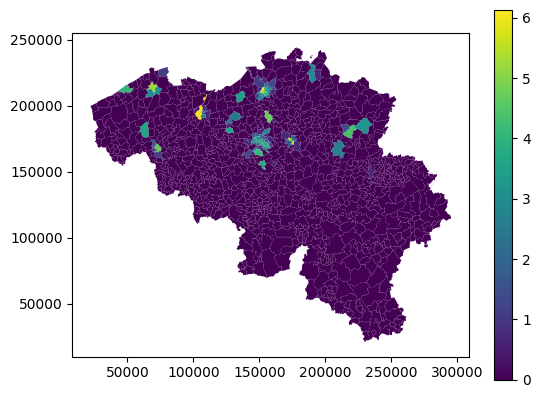

In [4]:
query = """
SELECT r.postal_code AS PostalCode, COUNT(r.id) AS RestaurantCount
FROM restaurants r
GROUP BY r.postal_code
"""

location_dist = pd.read_sql_query(query, deliveroo_conn)
location_dist['PostalCode'] = pd.to_numeric(location_dist['PostalCode'], errors='coerce')
dist = geographic_df.merge(location_dist, on='PostalCode', how='left').fillna(0)
dist['RestaurantCountLog'] = dist['RestaurantCount'].apply(lambda x: np.log1p(x))
dist.plot('RestaurantCountLog', legend=True)

<Axes: >

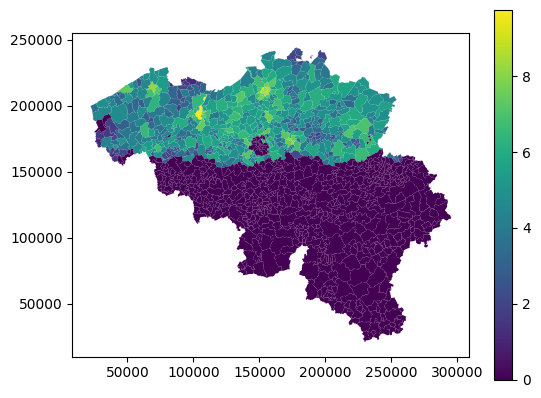

In [5]:
query = """
SELECT l.postalCode AS PostalCode, COUNT(r.restaurant_id) AS RestaurantCount
FROM restaurants r
JOIN locations_to_restaurants ltr ON r.primarySlug = ltr.restaurant_id
JOIN locations l ON ltr.location_id = l.ID
GROUP BY l.postalCode
"""

location_dist = pd.read_sql_query(query, takeaway_conn)
dist = geographic_df.merge(location_dist, on='PostalCode', how='left').fillna(0)
dist['RestaurantCountLog'] = dist['RestaurantCount'].apply(lambda x: np.log1p(x))
dist.plot('RestaurantCountLog', legend=True)

<Axes: >

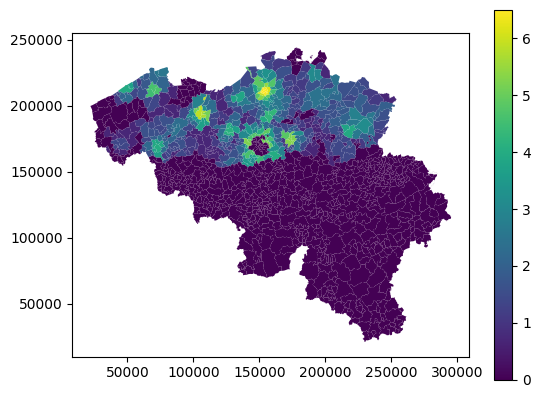

In [6]:
query = """
SELECT DISTINCT r.title, l.name, l.region AS PostalCode, COUNT(DISTINCT r.title) AS RestaurantCount
FROM restaurants r
JOIN locations_to_restaurants ltr ON r.id = ltr.restaurant_id
JOIN locations l ON ltr.location_id = l.id
GROUP BY PostalCode
"""

location_dist = pd.read_sql_query(query, ubereats_conn)
location_dist['PostalCode'] = pd.to_numeric(location_dist['PostalCode'], errors='coerce')
dist = geographic_df.merge(location_dist, on='PostalCode', how='left').fillna(0)
dist['RestaurantCountLog'] = dist['RestaurantCount'].apply(lambda x: np.log1p(x))
dist.plot('RestaurantCountLog', legend=True)

# 4. Map locations offering kapsalons and their average price.

<Axes: >

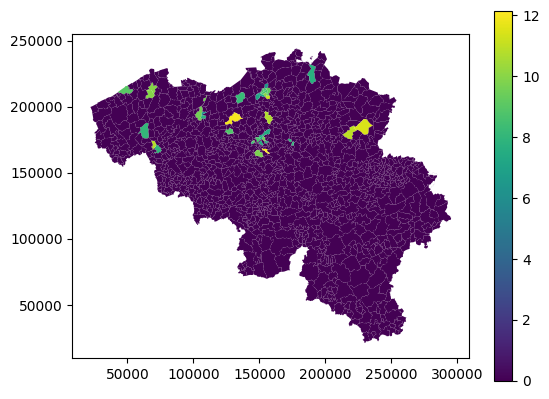

In [7]:
query = """
SELECT r.postal_code AS PostalCode, c.name, AVG(mi.price) AS price
FROM restaurants r
JOIN categories c ON r.id = c.restaurant_id
JOIN menu_items mi ON c.categorie_id = mi.categorie_id
WHERE c.name LIKE '%kapsalon%'
GROUP BY r.postal_code
"""

data = pd.read_sql_query(query, deliveroo_conn)
data['PostalCode'] = pd.to_numeric(data['PostalCode'], errors='coerce')
dist = geographic_df.merge(data, on='PostalCode', how='left').fillna(0)
dist.plot('price', legend=True)

<Axes: >

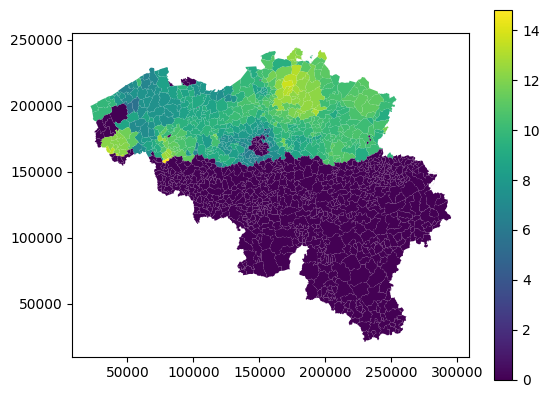

In [8]:
query = """
SELECT c.name AS category, AVG(m.price) AS price, l.postalCode AS PostalCode
FROM restaurants r
JOIN menuItems m ON r.primarySlug = m.primarySlug
JOIN categories c ON r.primarySlug = c.restaurant_id
JOIN locations_to_restaurants ltr ON r.primarySlug = ltr.restaurant_id
JOIN locations l ON ltr.location_id = l.ID
WHERE c.name LIKE '%kapsalon%'
GROUP BY PostalCode
ORDER BY price DESC
"""

data = pd.read_sql_query(query, takeaway_conn)
dist = geographic_df.merge(data, on='PostalCode', how='left').fillna(0)
dist.plot('price', legend=True)

<Axes: >

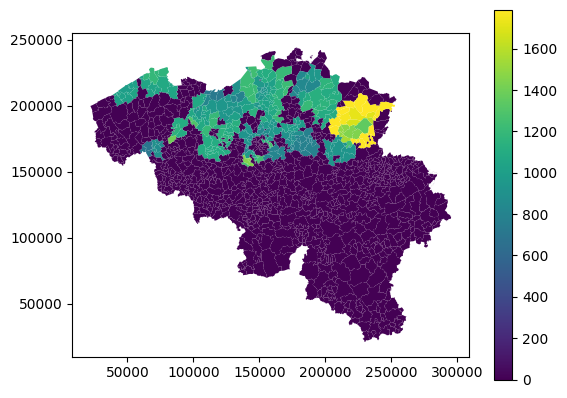

In [9]:
query = """
SELECT r.title, AVG(mi.price) AS price, l.region AS PostalCode, rtc.category, mi.name
FROM restaurants r
JOIN menu_items mi ON r.id = mi.restaurant_id
JOIN locations_to_restaurants ltr ON r.id = ltr.restaurant_id
JOIN locations l ON ltr.location_id = l.id
JOIN restaurant_to_categories rtc ON r.id = rtc.restaurant_id
WHERE mi.name LIKE '%kapsalon%'
GROUP BY PostalCode
"""

data = pd.read_sql_query(query, ubereats_conn)
data.head()
data['PostalCode'] = pd.to_numeric(data['PostalCode'], errors='coerce')
dist = geographic_df.merge(data, on='PostalCode', how='left').fillna(0)
dist.plot('price', legend=True)

## 6. Create a Venn diagram comparing restaurant distributions across Uber Eats, Deliveroo, and Takeaway. Discuss trends.

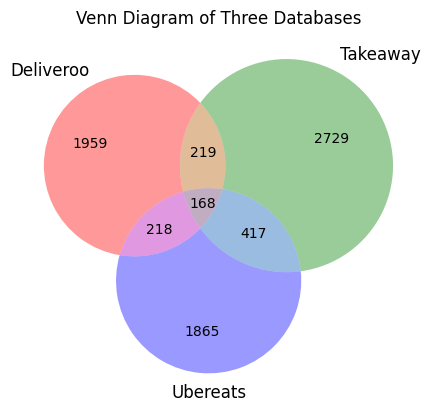

In [10]:
# Query unique names from each database
deliveroo.execute("SELECT DISTINCT name FROM restaurants")
ids1 = set(row[0] for row in deliveroo.fetchall())
takeaway.execute("SELECT DISTINCT name FROM restaurants")
ids2 = set(row[0] for row in takeaway.fetchall())
ubereats.execute("SELECT DISTINCT r.title FROM restaurants r")
ids3 = set(row[0] for row in ubereats.fetchall())

# Unique to each database
only_in_1 = ids1 - ids2 - ids3
only_in_2 = ids2 - ids1 - ids3
only_in_3 = ids3 - ids1 - ids2
# Pairwise overlaps
in_1_and_2 = (ids1 & ids2) - ids3
in_1_and_3 = (ids1 & ids3) - ids2
in_2_and_3 = (ids2 & ids3) - ids1
# Overlap in all three
in_all = ids1 & ids2 & ids3

# Sizes for the Venn diagram
venn = venn3(
    subsets=(
        len(only_in_1),      # Unique to DB1
        len(only_in_2),      # Unique to DB2
        len(in_1_and_2),     # Shared by DB1 and DB2
        len(only_in_3),      # Unique to DB3
        len(in_1_and_3),     # Shared by DB1 and DB3
        len(in_2_and_3),     # Shared by DB2 and DB3
        len(in_all)          # Shared by all three
    ),
    set_labels=("Deliveroo", "Takeaway", "Ubereats")
)

# Customize the plot
plt.title("Venn Diagram of Three Databases")
plt.show()

## 7. How do delivery fees vary across platforms and locations?


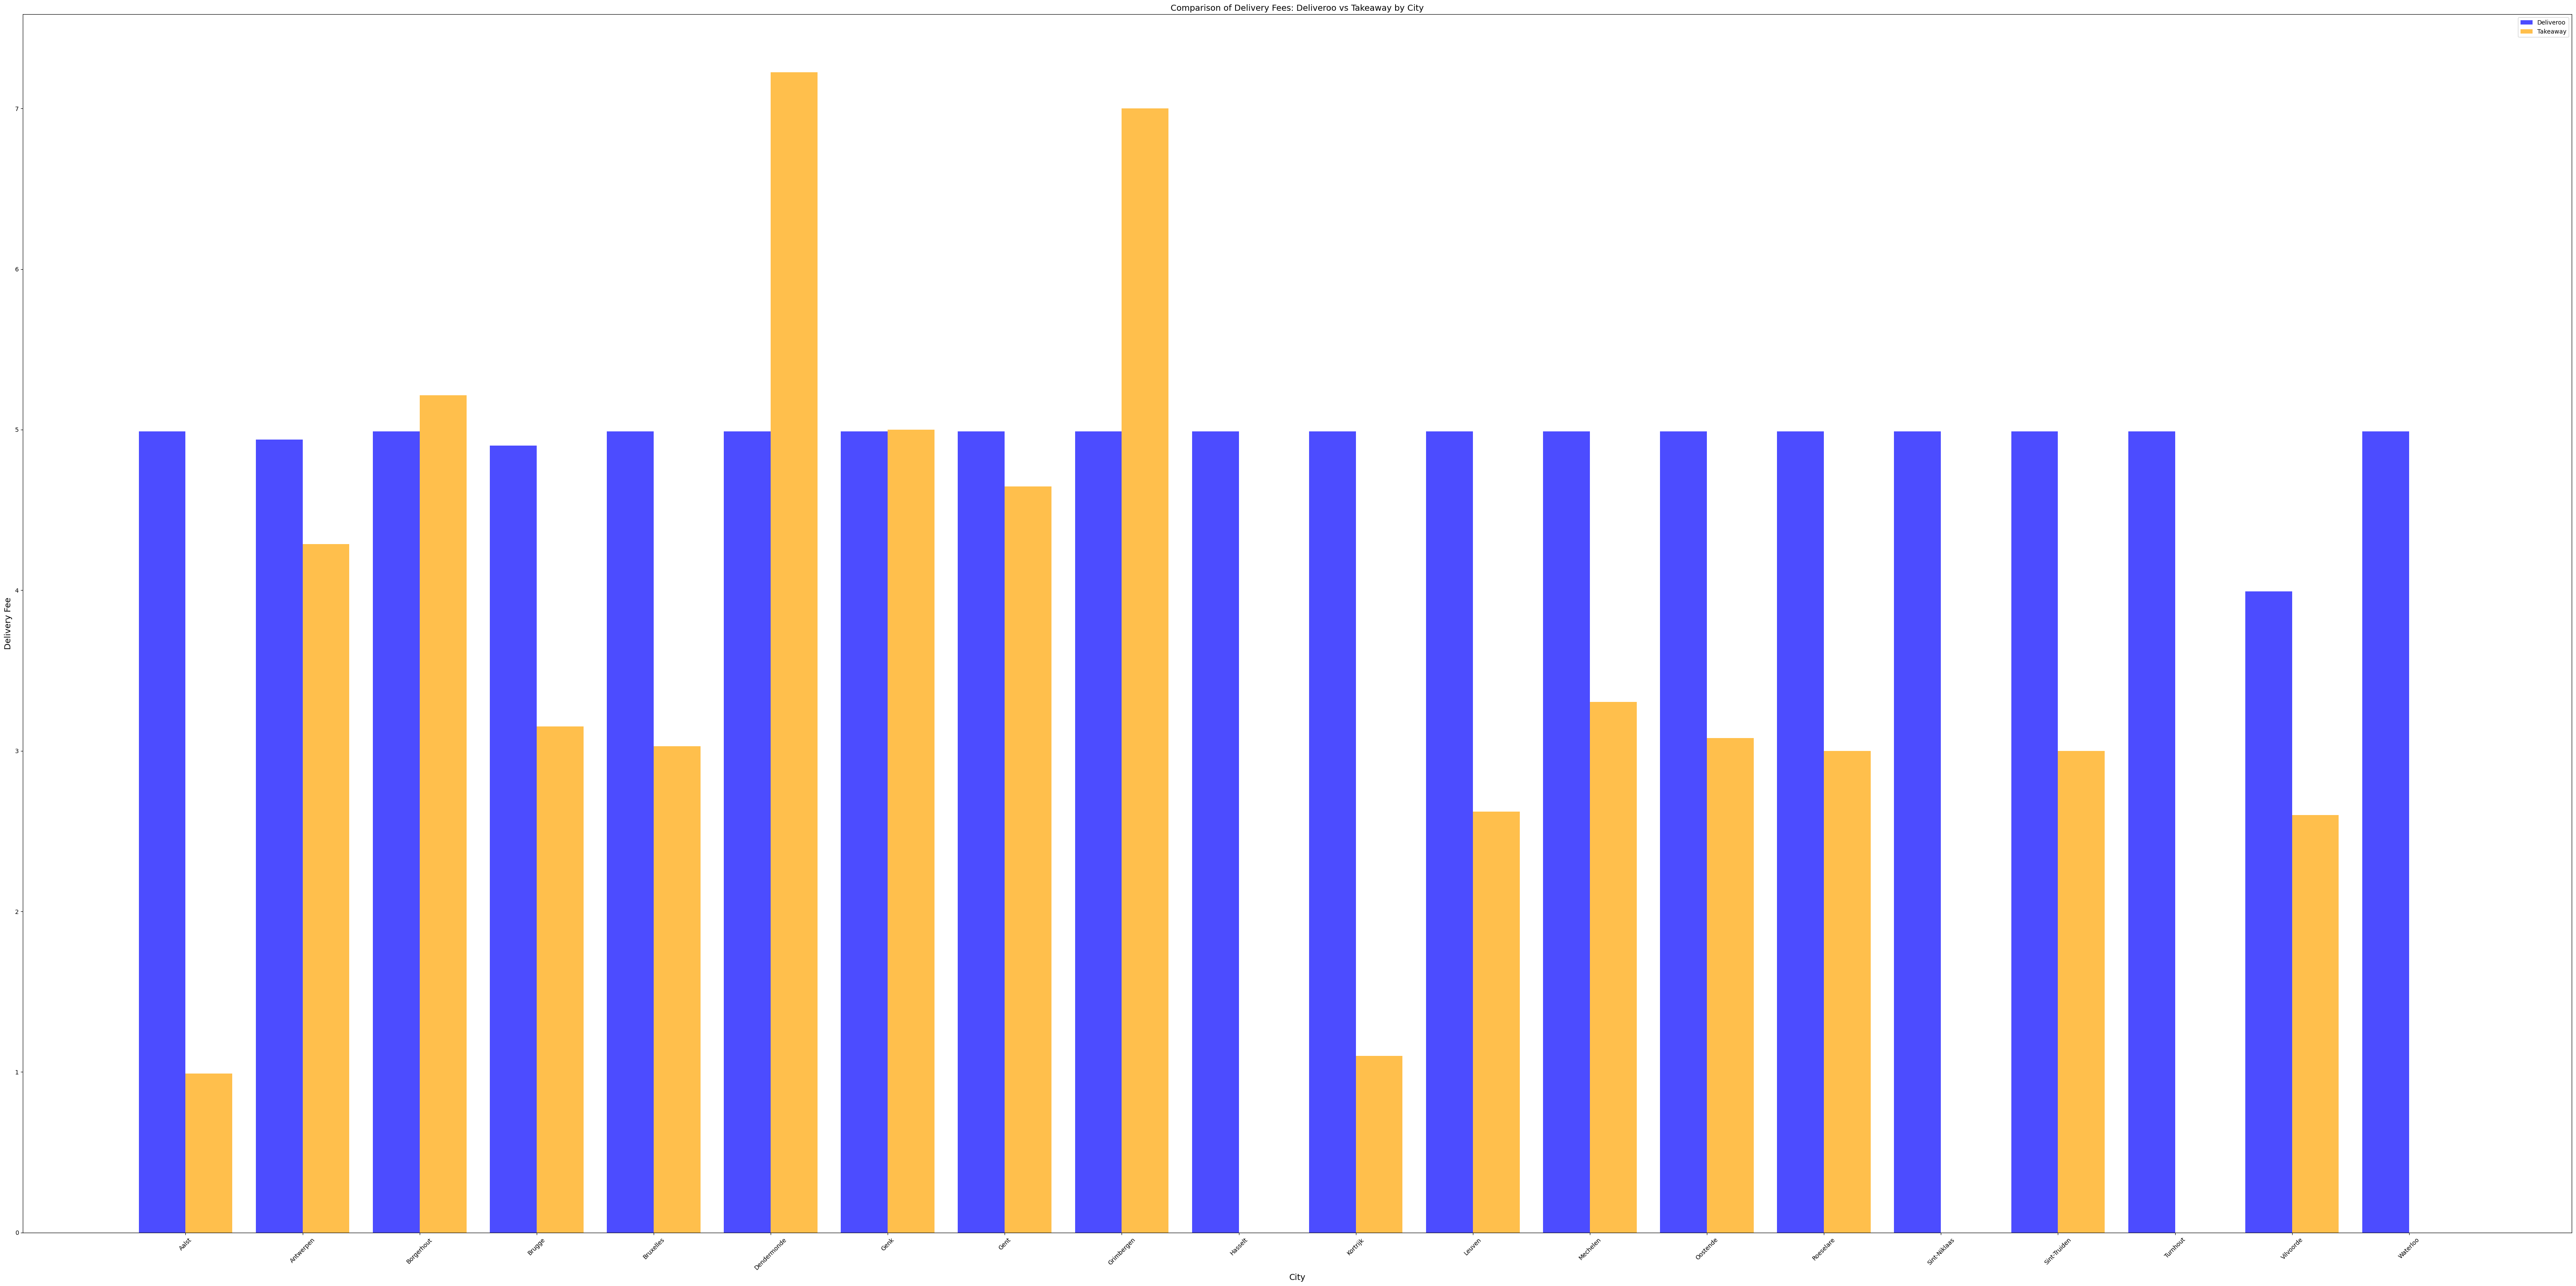

In [11]:
# Queries for fetching data from both databases
query = "SELECT name, delivery_fee, latitude, longitude FROM restaurants"
query1 = "SELECT city, deliveryFee, latitude, longitude FROM restaurants"

# Fetching data from the two connections
data = pd.read_sql_query(query, deliveroo_conn)
data1 = pd.read_sql_query(query1, takeaway_conn)

# Renaming columns for consistency
data.rename(columns={'delivery_fee': 'deliveryFee'}, inplace=True)

# Ensure deliveryFee columns are numeric
data['deliveryFee'] = pd.to_numeric(data['deliveryFee'], errors='coerce')
data1['deliveryFee'] = pd.to_numeric(data1['deliveryFee'], errors='coerce')

# Merging the two datasets based on latitude and longitude
merged_data = pd.merge(data, data1, on=['latitude', 'longitude'], suffixes=('_deliveroo', '_takeaway'))

# Adding a column to calculate the numeric difference
merged_data['fee_difference'] = merged_data['deliveryFee_deliveroo'] - merged_data['deliveryFee_takeaway']

Fees = merged_data[merged_data['fee_difference'] != 0]

#by restaurant
Fees = Fees.drop(columns=['latitude', 'longitude'])

#by city
FeesbyCity = Fees.drop(columns=['name'])


city_mapping = {
    "Schaarbeek": "Bruxelles",
    "Anvers": "Antwerpen",
    "Alost": "Aalst",
    "Bruges": "Brugge",
    "Courtrai": "Kortrijk",
    "Malines": "Mechelen",
    "Ostende": "Oostende",
    "Roulers": "Roeselare",
    "Saint-Nicolas": "Sint-Niklaas",
    "Termonde": "Dendermonde",
    "Tournai": "Doornik",
    "Ypres": "Ieper",
    "Zottegem": "Bruxelles",
    "Woluwé-Saint-Lambert": "Bruxelles",
    "Woluwe-Saint-Pierre": "Bruxelles",
    "Woluwé-Saint-Pierre": "Bruxelles",
    "Sint-Pieters-Leeuw": "Bruxelles",
    "Gand": "Gent",
    "Uccle": "Bruxelles",
    "Vilvorde": "Vilvoorde",
    "Borgherout": "Antwerpen",
    "Berchem": "Antwerpen",
    "Wilrijk": "Antwerpen",
    "Evere": "Bruxelles",
    "Forest": "Bruxelles",
    "Berchem-Sainte-Agathe": "Bruxelles",
    "Drogenbos": "Bruxelles",
    "Ganshoren": "Bruxelles",
    "Jette": "Bruxelles",
    "Heverlee": "Leuven",
    "Kessel-Lo": "Leuven",
    "Kraainem": "Bruxelles",
    "Laeken": "Bruxelles",
    "Molenbeek-Saint-Jean": "Bruxelles",
    "Ledeberg": "Gent",
    "Merksem": "Antwerpen",
    "Schaerbeek": "Bruxelles",
    "Strombeek-Bever": "Bruxelles",
    "Ukkel": "Bruxelles",
    "Wijnegem": "Antwerpen",
    "Wilrijk": "Antwerpen",
    "Sint-Andries": "Brugge",
    "Deurne": "Antwerpen"

    
    
}
# Standardize city names using the mapping
FeesbyCity['city'] = FeesbyCity['city'].replace(city_mapping)
FeesbyCity = FeesbyCity.groupby(by=['city'], as_index=False).mean()
FeesbyCity = FeesbyCity.drop(index=0)


# Export the Fees to a CSV file
Fees.to_csv('Fees.csv', index=False)
FeesbyCity.to_csv('FeesByCity.csv', index = False)
# Create a bar plot comparing fees from Deliveroo and Takeaway by city
fig, ax = plt.subplots(figsize=(60, 30))

# Plot the delivery fees side by side
x = range(len(FeesbyCity))
width = 0.4

ax.bar(x, FeesbyCity['deliveryFee_deliveroo'], width=width, label='Deliveroo', color='blue', alpha=0.7)
ax.bar([i + width for i in x], FeesbyCity['deliveryFee_takeaway'], width=width, label='Takeaway', color='orange', alpha=0.7)

# Add labels, title, and legend
ax.set_xlabel('City', fontsize=14)
ax.set_ylabel('Delivery Fee', fontsize=14)
ax.set_title('Comparison of Delivery Fees: Deliveroo vs Takeaway by City', fontsize=14)
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(FeesbyCity['city'], rotation=45, fontsize=10)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()



## 8. Which restaurants have the best price-to-rating ratio?


In [12]:
query = """
SELECT r.name, (AVG(r.rating) / SUM(mi.price)) AS ratio
FROM restaurants r
JOIN categories c ON r.id = c.restaurant_id
JOIN menu_items mi ON c.categorie_id = mi.categorie_id
GROUP BY r.name
ORDER BY ratio DESC
"""

data =  pd.read_sql_query(query, deliveroo_conn)
data.head()

,name,ratio
0,Carrefour Express Voskenslaan,0.249680
1,Stadsbrouwerij De Koninck,0.242105
2,#Kitchens,0.232432
3,Café Pistolet,0.219048
4,Bubble Land,0.186667


In [13]:
query = """
SELECT r.name, (AVG(r.ratings) / SUM(mi.price)) AS ratio
FROM restaurants r
JOIN menuItems mi ON r.primarySlug = mi.primarySlug
GROUP BY r.name
ORDER BY ratio DESC
"""

data =  pd.read_sql_query(query, takeaway_conn)
data.head()

,name,ratio
0,El Bocadillos,0.350000
1,Pâtisserie Doce Tentação,0.238095
2,Hard Rock Cafe,0.183529
3,Rumah Jawa,0.177778
4,Au Petit En Cas (chez Lucie),0.157692


In [14]:
query = """
SELECT r.title, (AVG(r.rating__rating_value) / SUM(mi.price)) AS ratio
FROM restaurants r
JOIN menu_items mi ON r.id = mi.restaurant_id
GROUP BY r.title
ORDER BY ratio DESC
"""

data =  pd.read_sql_query(query, ubereats_conn)
data.head()

,title,ratio
0,So Sushi Dilbeek,0.015000
1,RUBA - Healthy Fresh Food,0.013143
2,O'Tacos - Mechelen,0.011429
3,PokÃ© House - Antwerpen,0.009250
4,Belchicken - Basilix,0.008039


## 11. How do ratings of similar restaurants differ across Uber Eats, Deliveroo, and Takeaway?

In [15]:
db1_df = pd.read_sql_query("SELECT r.name AS name, r.rating AS rating FROM restaurants r", deliveroo_conn)
db2_df = pd.read_sql_query("SELECT r.name AS name, r.ratings AS rating FROM restaurants r", takeaway_conn)
db3_df = pd.read_sql_query("SELECT r.title AS name, r.rating__rating_value AS rating FROM restaurants r", ubereats_conn)

# Normalize names for comparison
db1_df["normalized_name"] = db1_df["name"].str.lower().str.replace(" ", "").str.replace("'", "")
db2_df["normalized_name"] = db2_df["name"].str.lower().str.replace(" ", "").str.replace("'", "")
db3_df["normalized_name"] = db3_df["name"].str.lower().str.replace(" ", "").str.replace("'", "")

db3_df.rename(columns={"rating": "rating_db3"}, inplace=True)
# Merge DataFrames on normalized names
merged = db1_df.merge(db2_df, on="normalized_name", how="inner", suffixes=("_db1", "_db2"))
merged = merged.merge(db3_df, on="normalized_name", how="inner", suffixes=("", "_db3"))

merged["rating_diff_db1_db2"] = merged["rating_db1"] - merged["rating_db2"]
merged["rating_diff_db1_db3"] = merged["rating_db1"] - merged["rating_db3"]
merged["rating_diff_db2_db3"] = merged["rating_db2"] - merged["rating_db3"]

data = merged.iloc[:15]

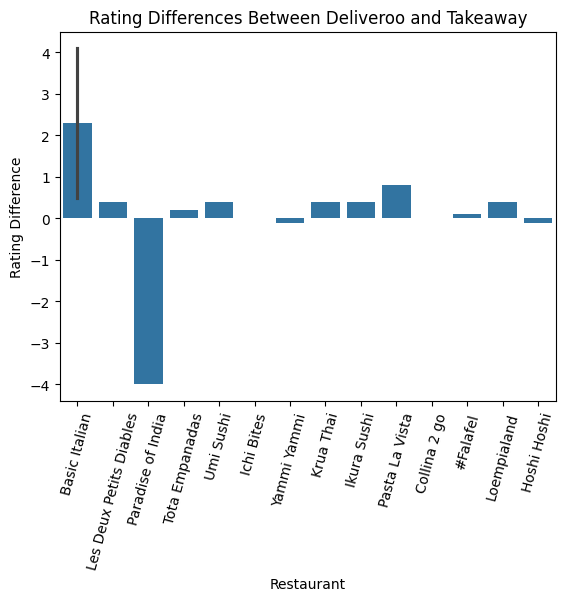

In [16]:
sns.barplot(data, x="name_db1", y="rating_diff_db1_db2")
plt.xticks(rotation=75)
plt.title("Rating Differences Between Deliveroo and Takeaway")
plt.ylabel("Rating Difference")
plt.xlabel("Restaurant")
plt.show()

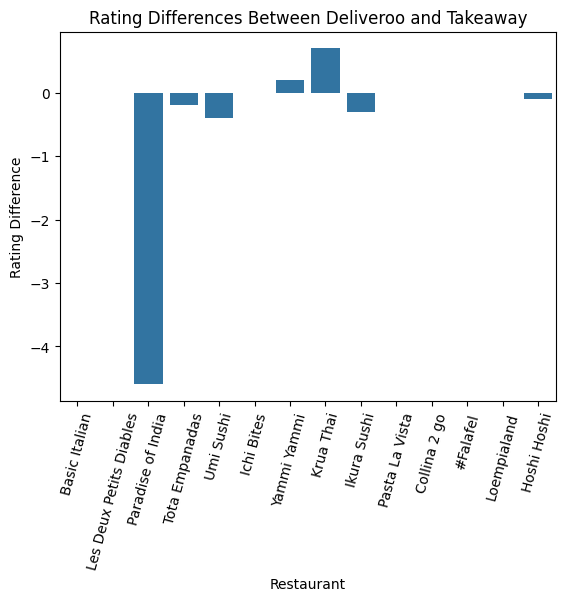

In [17]:
sns.barplot(data, x="name_db1", y="rating_diff_db1_db3")
plt.xticks(rotation=75)
plt.title("Rating Differences Between Deliveroo and Takeaway")
plt.ylabel("Rating Difference")
plt.xlabel("Restaurant")
plt.show()

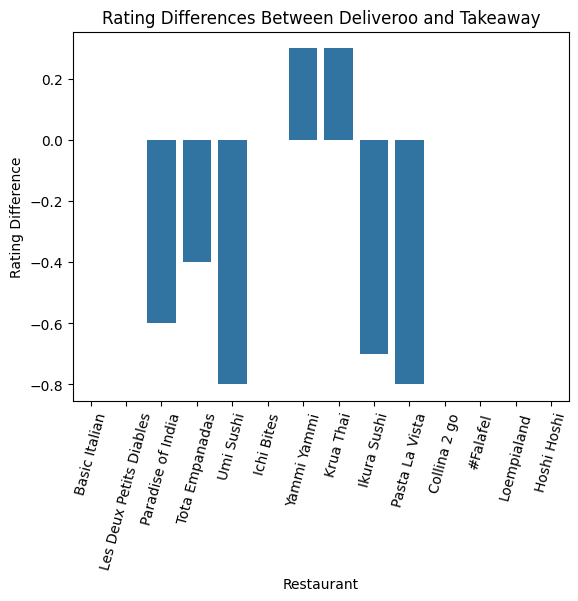

In [18]:
sns.barplot(data, x="name_db1", y="rating_diff_db2_db3")
plt.xticks(rotation=75)
plt.title("Rating Differences Between Deliveroo and Takeaway")
plt.ylabel("Rating Difference")
plt.xlabel("Restaurant")
plt.show()

## 12 WHO ??

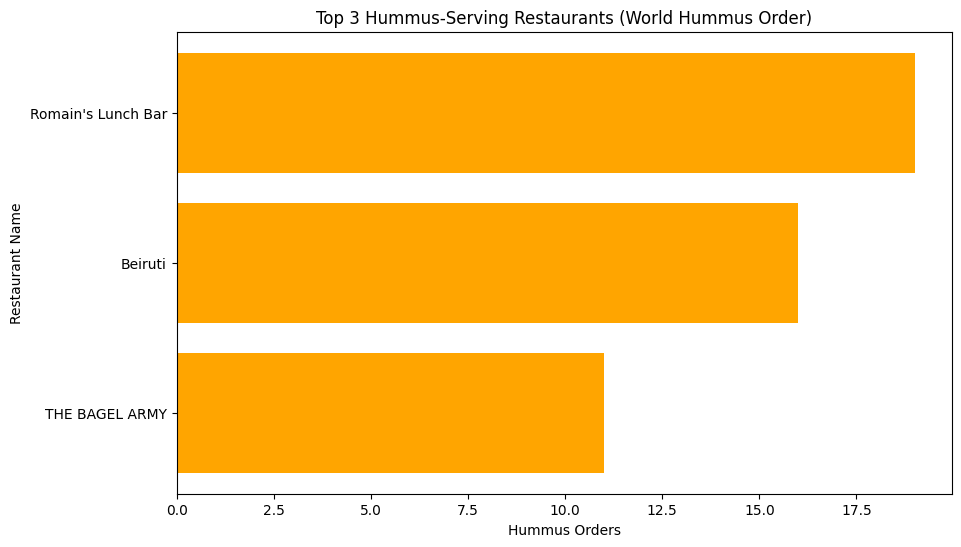

        restaurant_name  hummus_orders
290  Romain's Lunch Bar             19
39              Beiruti             16
311      THE BAGEL ARMY             11


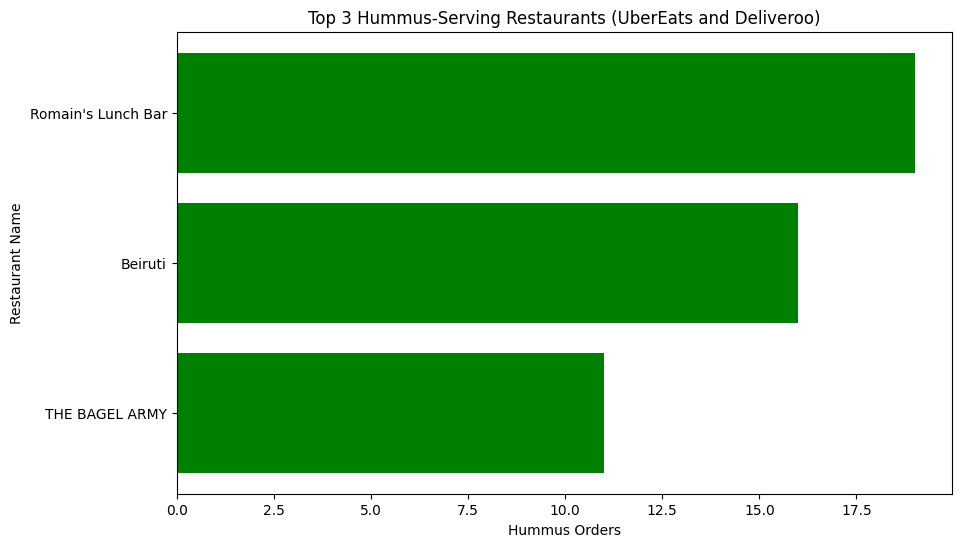

,restaurant_name,hummus_orders
290,Romain's Lunch Bar,19
39,Beiruti,16
311,THE BAGEL ARMY,11


In [19]:
import sqlite3
# File paths for the uploaded databases
ubereats_path = './databases/ubereats.db'
takeaway_path = './databases/takeaway.db'
deliveroo_path = './databases/deliveroo.db'

# Function to fetch the schema of a database
def fetch_schema(db_path):
    with sqlite3.connect(db_path) as conn:
        query = "SELECT name FROM sqlite_master WHERE type='table';"
        tables = conn.execute(query).fetchall()
        schema = {}
        for table in tables:
            table_name = table[0]
            columns = conn.execute(f"PRAGMA table_info({table_name})").fetchall()
            schema[table_name] = [(col[1], col[2]) for col in columns]  # Column name and type
        return schema

# Fetch schemas for the databases
ubereats_schema = fetch_schema(ubereats_path)
takeaway_schema = fetch_schema(takeaway_path)
deliveroo_schema = fetch_schema(deliveroo_path)

ubereats_schema, takeaway_schema, deliveroo_schema

# Function to extract hummus data from a database
def fetch_hummus_data(db_path, menu_table, restaurant_table, menu_name_col, restaurant_id_col, restaurant_name_col):
    with sqlite3.connect(db_path) as conn:
        # Query for hummus items in the menu
        query = f"""
        SELECT r.{restaurant_name_col} AS restaurant_name, COUNT(*) AS hummus_orders
        FROM {menu_table} m
        JOIN {restaurant_table} r
        ON m.{restaurant_id_col} = r.id
        WHERE LOWER(m.{menu_name_col}) LIKE '%hummus%'
        GROUP BY r.{restaurant_name_col}
        """
        return pd.read_sql_query(query, conn)
# Function to fetch hummus data specifically for takeaway.db
def fetch_hummus_data_takeaway(db_path, menu_table, menu_name_col):
    with sqlite3.connect(db_path) as conn:
        # Query for hummus items in the menu (without join)
        query = f"""
        SELECT {menu_name_col} AS dish_name, COUNT(*) AS hummus_orders
        FROM {menu_table}
        WHERE LOWER({menu_name_col}) LIKE '%hummus%'
        GROUP BY {menu_name_col}
        """
        return pd.read_sql_query(query, conn)

# Fetch hummus data from takeaway.db using the revised approach
takeaway_hummus = fetch_hummus_data_takeaway(takeaway_path, "menuItems", "name")
takeaway_hummus

# Extract hummus data from all three databases
ubereats_hummus = fetch_hummus_data(ubereats_path, "menu_items", "restaurants", "name", "restaurant_id", "title")
#takeaway_hummus = fetch_hummus_data(takeaway_path, "menuItems", "restaurants", "name", "restaurant_id", "name")
deliveroo_hummus = fetch_hummus_data(deliveroo_path, "menu_items", "restaurants", "name", "restaurant_id", "name")

# Combine the data from all sources
all_hummus_data = pd.concat([ubereats_hummus, takeaway_hummus, deliveroo_hummus], ignore_index=True)

# Aggregate orders by restaurant
top_hummus_restaurants = all_hummus_data.groupby("restaurant_name", as_index=False).sum()
top_hummus_restaurants = top_hummus_restaurants.sort_values(by="hummus_orders", ascending=False).head(3)

# Visualize the top 3 hummus-serving restaurants
plt.figure(figsize=(10, 6))
plt.barh(top_hummus_restaurants["restaurant_name"], top_hummus_restaurants["hummus_orders"], color="orange")
plt.xlabel("Hummus Orders")
plt.ylabel("Restaurant Name")
plt.title("Top 3 Hummus-Serving Restaurants (World Hummus Order)")
plt.gca().invert_yaxis()  # Invert y-axis for ranking order
plt.show()

top_hummus_restaurants


# Inspect columns of `menuItems` and `restaurants` tables in takeaway.db
with sqlite3.connect(takeaway_path) as conn:
    menu_items_columns = conn.execute("PRAGMA table_info(menuItems);").fetchall()
    restaurants_columns = conn.execute("PRAGMA table_info(restaurants);").fetchall()

menu_items_columns, restaurants_columns


# Re-fetch hummus data from UberEats and Deliveroo databases only
ubereats_hummus = fetch_hummus_data(ubereats_path, "menu_items", "restaurants", "name", "restaurant_id", "title")
deliveroo_hummus = fetch_hummus_data(deliveroo_path, "menu_items", "restaurants", "name", "restaurant_id", "name")

# Combine the data from UberEats and Deliveroo
filtered_hummus_data = pd.concat([ubereats_hummus, deliveroo_hummus], ignore_index=True)

# Aggregate orders by restaurant
top_hummus_restaurants_filtered = filtered_hummus_data.groupby("restaurant_name", as_index=False).sum()
top_hummus_restaurants_filtered = top_hummus_restaurants_filtered.sort_values(by="hummus_orders", ascending=False).head(3)
print(top_hummus_restaurants_filtered)
# Visualize the top 3 hummus-serving restaurants
plt.figure(figsize=(10, 6))
plt.barh(top_hummus_restaurants_filtered["restaurant_name"], top_hummus_restaurants_filtered["hummus_orders"], color="green")
plt.xlabel("Hummus Orders")
plt.ylabel("Restaurant Name")
plt.title("Top 3 Hummus-Serving Restaurants (UberEats and Deliveroo)")
plt.gca().invert_yaxis()  # Invert y-axis for ranking order
plt.show()

top_hummus_restaurants_filtered

